# Disentangling obesity and diabetes in pancreatic islets 

In [1]:
import scanpy as sc
import anndata as ad
import DeepDive
import seaborn as sns
import numpy as np
import scipy 
from statsmodels.stats.multitest import multipletests
import matplotlib.pyplot as plt

import torch
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import cohen_kappa_score, average_precision_score, accuracy_score
from memelite.io import read_meme
from memelite.fimo import _fast_hits, _fast_convert, _all_pwm_to_mapping
import pychromvar as pc
import mygene
from anndata import AnnData
from statsmodels.stats.multitest import multipletests
import gseapy as gp
import statsmodels.formula.api as smf
from statsmodels.tools.tools import add_constant
from statsmodels.regression.linear_model import OLS
from scipy.stats import pearsonr, spearmanr

import os
import glob

In [2]:
import sys
sys.path.insert(0, "../utils")

In [3]:
from utils import preprocess, set_dropout
from pancreas import covariate_importance, calculate_metric, compare_groups_de, compute_deviations, permutation_test, counterfactual_prediction

## Load data and train DeepDive model

In [4]:
n_decoders = 10
model_params = {
    'n_epochs_pretrain_ae' : 200*n_decoders,
    'n_decoders' : n_decoders,
}

train_params = {
    'max_epoch' : 300*n_decoders, 
    'batch_size' : 512, 
}

In [5]:
adata = sc.read_h5ad("../data/islet.h5ad")

In [6]:
mapper = {0:'alpha',
1:'beta', 
2:'beta', 
3:'beta', 
4:'alpha', 
5:'beta', 
6:'delta', 
7:'acinar', 
8:'alpha', 
9:'ductal', 
10:'gamma', 
11:'stellate', 
12:'immune', 
13:'endothelial',
}
adata.obs['celltype'] = adata.obs.leiden.map(mapper)

In [7]:
discrete_covriate_keys = ['donor', 'celltype', 'Center', 'Disease', 'Storage', 'Gender', 'Race']
continuous_covriate_keys = ['Age', 'BMI', 'HbA1c', 'Purity', 'map_frac']

In [8]:
adata = preprocess(adata, discrete_covriate_keys, continuous_covriate_keys, frac = 0.01).copy()

In [9]:
model = DeepDive.DeepDive(adata = adata, 
                        discrete_covariate_names = discrete_covriate_keys,
                        continuous_covariate_names = continuous_covriate_keys, 
                        **model_params                
                       )

In [10]:
model_path = f'../models/Pancreas/pancreas.pt'
if not os.path.exists(model_path):
    model.train_model(adata, None, **train_params)
    torch.save(model.state_dict(), model_path)
else:
    model.load_state_dict(torch.load(model_path))
    print("Loaded model")

Loaded model


In [11]:
set_dropout(model)

## Covariate importance

In [12]:
res= covariate_importance(model, 'celltype')

In [13]:
res = pd.DataFrame({i:res[i].set_index('Covariate')['Importance'] for i in model.data_register['covariate_names_unique']['celltype'][:-1]})

In [14]:
order = res.idxmax(axis = 1).sort_values().index
colorder = ['alpha', 'beta','gamma', 'delta', 'acinar', 'ductal', 'endothelial','immune', 'stellate']

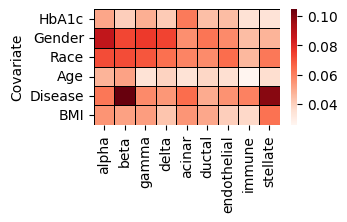

In [15]:
plt.subplots(figsize=(3, 1.5))
sns.heatmap(res.loc[order, colorder], cmap = 'Reds', linecolor = 'k', linewidth = 0.5)
plt.savefig('../figures/F2B.pdf')

## Unknown variation

In [16]:
basal = model.get_latent(adata, covars_to_add = [])

In [ ]:
sc.pp.neighbors(basal, n_neighbors=15)
sc.tl.umap(basal, )
basal_subset = sc.pp.subsample(basal, n_obs = 50_000, copy = True)
sc.pl.umap(basal_subset, color = ['celltype'], save = 'S5A', )


... storing 'celltype' as categorical


## Differentially accessible peaks

In [16]:
eps = 1e-8
p_thresh = 0.01
de_diff = 0.1

In [17]:
background = {'celltype':'beta'}

In [18]:
DE_diabetes = compare_groups_de(model, adata, covariate="Disease", groupA="T2D", groupB="Non", background = background)
DE_diabetes['Significant'] = (DE_diabetes.FDR <= p_thresh) & (np.abs(DE_diabetes.Difference) >= de_diff)

In [19]:
DE_BMI = compare_groups_de(model, adata, 'BMI', background = background)
DE_BMI['Significant'] = (DE_BMI.FDR <= p_thresh) & (np.abs(DE_BMI.Difference) >= de_diff)

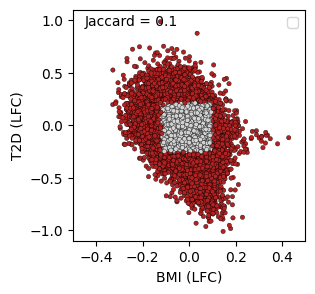

In [20]:
plt.subplots(figsize=(3,3))
sns.scatterplot(x = DE_BMI.Difference, y = DE_diabetes.Difference, hue = DE_BMI.Significant | DE_diabetes.Significant, edgecolor = 'k', palette = ['lightgrey', 'firebrick'], s = 10)
plt.legend([])
plt.ylim(-1.1, 1.1)
plt.xlim(-0.5, 0.5)

plt.xlabel('BMI (LFC)')
plt.ylabel('T2D (LFC)')

A = set(DE_BMI[DE_BMI.Significant].Feature.tolist())
B = set(DE_diabetes[DE_diabetes.Significant].Feature.tolist())
C = A.intersection(B)
D = A.union(B)
j = float(len(C))/float(len(D))
plt.text(x = -0.45, y = 1-0.05, s = f'Jaccard = {round(j, 2)}')

plt.savefig('../figures/S5B.pdf')

## Enrichment of GWAS variants

In [21]:
df = pd.DataFrame([DE_BMI.Feature, DE_BMI.Significant, DE_diabetes.Significant], index = ['Feature', 'BMI', 'T2D']).T

In [22]:
df['group'] = df[['BMI', 'T2D']].apply(lambda x: x.map(int)).idxmax(axis = 1)#colmax#.sum(axis = 1)

In [23]:
df['Sum'] = df[['BMI', 'T2D']].apply(lambda x: x.map(int)).sum(axis = 1)

In [24]:
df.loc[df.Sum == 0, 'group'] = 'NS'
df.loc[df.Sum == 2, 'group'] = 'Both'

In [25]:
for i in df.group.unique():
    tmp = df[df.group == i]
    
    #pd.DataFrame([split(x) for x in tmp.Feature]).to_csv(f'../results/GWAS_enrich/peaks/{i}.bed',sep = '\t', 
    #                                                     header = None, index=False)

In [26]:
# Run bash script: scripts/LDSC.sh 

In [27]:
# Define the path to results
results_dir = "../results/GWAS_enrich/results/"
result_files = glob.glob(os.path.join(results_dir, "*.results"))

In [28]:
map_label = {'group_BothL2_0':'Both', 'group_BMIL2_0':'BMI', 'group_T2DL2_0':'T2D', 'group_NSL2_0':'NS'}

In [29]:
all_results = []

for fname in result_files:
    tmp_res = pd.read_csv(fname, sep="\t")
    tmp_res['Category'] =tmp_res.Category.map(lambda x: x.replace('group_', '').replace('L2_0', ''))
    
    base = os.path.basename(fname)
    underscore_idx = base.find('_')
    dot_idx = base.find('.')
    tmp_res["Trait"] = base[underscore_idx + 1 : dot_idx]
    all_results.append(tmp_res)

res = pd.concat(all_results, ignore_index=True)

res["Pval"] = -np.log10(res["Enrichment_p"])

_, fdr_corrected, _, _ = multipletests(res["Enrichment_p"], method='fdr_bh')
res["FDR"] = -np.log10(fdr_corrected)

In [30]:
order = ['Both', 'BMI', 'T2D', 'NS']

In [31]:
color = ['indianred','royalblue']

In [32]:
order = ['BMI', 'T2D']

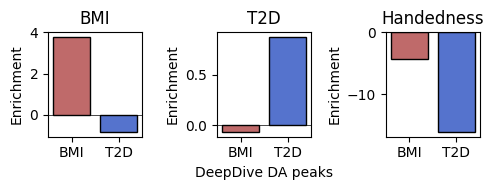

In [33]:
trait = 'BMI'
tmp = res[res.Trait == trait]
fig, ax = plt.subplots(1, 3, figsize=(5,2))

sns.barplot(tmp, x = 'Category', y = 'Enrichment', ax = ax[0], order = order, edgecolor = 'k', palette = color)
ax[0].axhline(0, color='k', linewidth=0.5)
ax[0].set_title(trait)

trait = 'T2D'
tmp = res[res.Trait == trait]

sns.barplot(tmp, x = 'Category', y = 'Enrichment', ax = ax[1], order = order, edgecolor = 'k', palette = color)
ax[1].axhline(0, color='k', linewidth=0.5)
ax[1].set_title(trait)

trait = 'Handedness'
tmp = res[res.Trait == trait]

sns.barplot(tmp, x = 'Category', y = 'Enrichment', ax = ax[2], order = order, edgecolor = 'k', palette = color)
ax[2].axhline(0, color='k', linewidth=0.5)
ax[2].set_title(trait)

ax[0].set_xlabel('')
ax[1].set_xlabel('DeepDive DA peaks')
ax[2].set_xlabel('')

plt.tight_layout()
plt.savefig('../figures/S5C.pdf')

## Covariate effects on beta cell subtype proportions

### Load subtype information

In [34]:
sub_meta = pd.read_csv('../data/Pancreas/AI_beta_subtype.csv', index_col = 2)

In [35]:
common_cells = adata.obs_names.intersection(sub_meta.index)
adata_subset = adata[common_cells].copy()
sub_meta_sorted = sub_meta.loc[adata_subset.obs_names]
adata_subset.obs["subtype"] = sub_meta_sorted["subtype"].values

### Reconstruct

In [36]:
recon_original = model.predict(
        adata_subset,
        covars_to_add=['celltype', 'Disease', 'Gender', 'Race', 'Age', 'BMI', 'HbA1c'],
        predict_mode='selected',
        add_unknown=True,
        library_size=10000,
    )

### Train classifier

In [37]:
# XGBoost parameters
max_depth = 3
fraction = 0.05
lr = 0.05
min_child_weight = 2
colsample_bytree = 0.1
model_path = "../models/Pancreas/xgb_model.json"
# Get datasets
features = np.array(((adata_subset.X > 0).sum(axis = 0) / 90290) >= fraction)[0,:]
X = np.array(recon_original.X)[:,features]
y = (recon_original.obs['subtype'] == "beta_2").astype(int).to_numpy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
X_train, X_eval, y_train, y_eval = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

# Make dataset object
X_train = xgb.QuantileDMatrix(X_train, y_train, max_bin = 15)
X_test = xgb.QuantileDMatrix(X_test, y_test, max_bin = 15, ref=X_train)
X_eval = xgb.QuantileDMatrix(X_eval, y_eval, max_bin = 15, ref=X_train)

if not os.path.exists(model_path):
    # Set evals
    evals = [(X_train, "train"), (X_eval, "eval")]
    print('Train model')

    # Define parameters
    params = {
        "tree_method": "gpu_hist",
        "predictor": "gpu_predictor",
        "learning_rate": lr,
        "min_child_weight": min_child_weight,
        "max_depth": max_depth,
        "colsample_bytree": colsample_bytree,
        "objective": "binary:logistic",
        "eval_metric": "logloss",
        "max_bin": 15
    }


    # Train model
    bst = xgb.train(
        params,
        X_train,
        num_boost_round=500,
        evals=evals,
        early_stopping_rounds=50,
        verbose_eval=False
    )

    # Save model
    bst.save_model(model_path)
else:
    print("Loading trained model.")
    bst = xgb.Booster()
    bst.load_model(model_path)

Loading trained model.


In [38]:
# Predicts
y_train_pred = bst.predict(X_train)
y_eval_pred = bst.predict(X_eval)
y_test_pred = bst.predict(X_test)

# Make dictionary
predictions = {
    'Train': {'Truth': y_train, 'Prediction': y_train_pred},
    'Eval': {'Truth': y_eval, 'Prediction': y_eval_pred},
    'Test': {'Truth': y_test, 'Prediction': y_test_pred}
}

# Calculate metrics
ds, met, score = [], [], []
for dataset in predictions.keys():
    for metric in ['Kappa', 'Accuracy','AP']:
        score.append(calculate_metric(bst, predictions[dataset]['Truth'], predictions[dataset]['Prediction'], metric))
        ds.append(dataset)
        met.append(metric)
        
# Create pandas object
results = pd.DataFrame({
    'Dataset': ds,
    'Metric': met,
    'Score': score
})

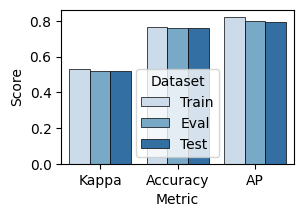

In [39]:
fig, ax = plt.subplots(1, 1, figsize=(3, 2))
kwargs = {'alpha':1, 
              'linewidth':0.5, 
              'edgecolor':'k'}
colors = ['lightgray', 'blue', 'green']

sns.barplot(y = 'Score', x = 'Metric', hue = 'Dataset', 
            palette = 'Blues', 
            data = results, **kwargs)
plt.savefig('../figures/S5E.pdf')

In [40]:
X_dmat = xgb.QuantileDMatrix(X, max_bin = 15, ref=X_train)
prediction = bst.predict(X_dmat)
recon_original.obs['predicted_subtype'] = (prediction >= 0.5).astype(int)
recon_original.obs['predicted_subtype'] = recon_original.obs['predicted_subtype'].map({0: 'beta_1', 1:'beta_2'})

In [41]:
means = recon_original.obs.assign(authorBeta2 = (recon_original.obs['subtype'] == 'beta_2').astype(int)).assign(modelBeta2 = (recon_original.obs['predicted_subtype'] == 'beta_2').astype(int)).groupby("donor").mean()

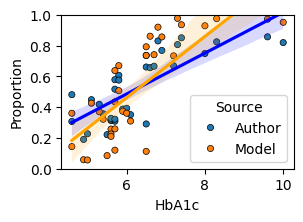

In [42]:
fig, ax = plt.subplots(1, 1, figsize=(3, 2))
author_df = means[['HbA1c', 'authorBeta2']]
author_df = author_df.rename(columns = {'authorBeta2': 'Proportion'})
author_df['Source'] = "Author"

model_df = means[['HbA1c', 'modelBeta2']]
model_df = model_df.rename(columns = {'modelBeta2': 'Proportion'})
model_df['Source'] = "Model"

combined = pd.concat((author_df, model_df))
sns.scatterplot(data=combined, x="HbA1c", y="Proportion", 
                hue="Source", edgecolor = 'k', linewidth = 0.5, s = 20)
sns.regplot(data=author_df, x="HbA1c", y="Proportion", ci=95, 
            scatter=False, label="Author", color="blue")
sns.regplot(data=model_df, x="HbA1c", y="Proportion", ci=95, 
            scatter=False, label="Model", color="orange")
plt.ylim(0, 1)
plt.savefig('../figures/S5F.pdf')

## Counterfactual prediction

In [43]:
# Define cells to include 
select_ND = (adata_subset.obs.celltype == 'beta') & (adata_subset.obs['Disease'] == 'Non' )
select_T2D = (adata_subset.obs.celltype == 'beta') & (adata_subset.obs['Disease'] == 'T2D' )

In [44]:
### Type 2 diabetics
## Get data
adata_T2D = adata_subset[select_T2D].copy()

## Counterfactual
# Original
T2D_original = counterfactual_prediction(model, adata_T2D,  {}, bst, features, X_train)

# Diabetes
T2D_to_ND = counterfactual_prediction(model, adata_T2D,  {'Disease':'Non'}, bst, features, X_train)

# HbA1c
HbA1c_step = 0.2 * (adata.obs['HbA1c'].max() - adata.obs['HbA1c'].min())
T2D_hba1c_one = counterfactual_prediction(model, adata_T2D,  {'HbA1c': -1 * HbA1c_step}, bst, features, X_train)
T2D_hba1c_two = counterfactual_prediction(model, adata_T2D,  {'HbA1c': -2 * HbA1c_step}, bst, features, X_train)
T2D_hba1c_three = counterfactual_prediction(model, adata_T2D,  {'HbA1c': -3 * HbA1c_step}, bst, features, X_train)
T2D_hba1c_four = counterfactual_prediction(model, adata_T2D,  {'HbA1c': -4 * HbA1c_step}, bst, features, X_train)

# Age
Age_step = 0.2 * (adata.obs['Age'].max() - adata.obs['Age'].min())
T2D_age_one = counterfactual_prediction(model, adata_T2D,  {'Age': -1 * Age_step}, bst, features, X_train)
T2D_age_two = counterfactual_prediction(model, adata_T2D,  {'Age': -2 * Age_step}, bst, features, X_train)
T2D_age_three = counterfactual_prediction(model, adata_T2D,  {'Age': -3 * Age_step}, bst, features, X_train)
T2D_age_four = counterfactual_prediction(model, adata_T2D,  {'Age': -4 * Age_step}, bst, features, X_train)

# BMI
BMI_step = 0.2 * (adata.obs['BMI'].max() - adata.obs['BMI'].min())
T2D_bmi_one = counterfactual_prediction(model, adata_T2D,  {'BMI': -1 * BMI_step}, bst, features, X_train)
T2D_bmi_two = counterfactual_prediction(model, adata_T2D,  {'BMI': -2 * BMI_step}, bst, features, X_train)
T2D_bmi_three = counterfactual_prediction(model, adata_T2D,  {'BMI': -3 * BMI_step}, bst, features, X_train)
T2D_bmi_four = counterfactual_prediction(model, adata_T2D,  {'BMI': -4 * BMI_step}, bst, features, X_train)

In [45]:
# Setup diabetes
original = pd.DataFrame({'donor': adata_T2D.obs['donor'],'Proportion': T2D_original}).groupby('donor').mean()
original['Counterfactual'] = 0
diabetes_cf = pd.DataFrame({'donor': adata_T2D.obs['donor'],'Proportion': T2D_to_ND}).groupby('donor').mean()
diabetes_cf['Counterfactual'] = 1
T2D_diabetes_cf = pd.concat((original, diabetes_cf))

# Setup HbA1c
HbA1c_one = pd.DataFrame({'donor': adata_T2D.obs['donor'],'Proportion': T2D_hba1c_one}).groupby('donor').mean()
HbA1c_one['Counterfactual'] = 0.2
HbA1c_two = pd.DataFrame({'donor': adata_T2D.obs['donor'],'Proportion': T2D_hba1c_two}).groupby('donor').mean()
HbA1c_two['Counterfactual'] = 0.4
HbA1c_three = pd.DataFrame({'donor': adata_T2D.obs['donor'],'Proportion': T2D_hba1c_three}).groupby('donor').mean()
HbA1c_three['Counterfactual'] = 0.6
HbA1c_four = pd.DataFrame({'donor': adata_T2D.obs['donor'],'Proportion': T2D_hba1c_four}).groupby('donor').mean()
HbA1c_four['Counterfactual'] = 0.8
T2D_HbA1c_cf = pd.concat((original, HbA1c_one, HbA1c_two, HbA1c_three, HbA1c_four))

# Setup BMI
BMI_one = pd.DataFrame({'donor': adata_T2D.obs['donor'],'Proportion': T2D_bmi_one}).groupby('donor').mean()
BMI_one['Counterfactual'] = 0.2
BMI_two = pd.DataFrame({'donor': adata_T2D.obs['donor'],'Proportion': T2D_bmi_two}).groupby('donor').mean()
BMI_two['Counterfactual'] = 0.4
BMI_three = pd.DataFrame({'donor': adata_T2D.obs['donor'],'Proportion': T2D_bmi_three}).groupby('donor').mean()
BMI_three['Counterfactual'] = 0.6
BMI_four = pd.DataFrame({'donor': adata_T2D.obs['donor'],'Proportion': T2D_bmi_four}).groupby('donor').mean()
BMI_four['Counterfactual'] = 0.8
T2D_BMI_cf = pd.concat((original, BMI_one, BMI_two, BMI_three, BMI_four))

# Setup age
Age_one = pd.DataFrame({'donor': adata_T2D.obs['donor'],'Proportion': T2D_age_one}).groupby('donor').mean()
Age_one['Counterfactual'] = 0.2
Age_two = pd.DataFrame({'donor': adata_T2D.obs['donor'],'Proportion': T2D_age_two}).groupby('donor').mean()
Age_two['Counterfactual'] = 0.4
Age_three = pd.DataFrame({'donor': adata_T2D.obs['donor'],'Proportion': T2D_age_three}).groupby('donor').mean()
Age_three['Counterfactual'] = 0.6
Age_four = pd.DataFrame({'donor': adata_T2D.obs['donor'],'Proportion': T2D_age_four}).groupby('donor').mean()
Age_four['Counterfactual'] = 0.8
T2D_Age_cf = pd.concat((original, Age_one, Age_two, Age_three, Age_four))

In [46]:
### Non-diabetics
## Get data
adata_ND = adata_subset[select_ND].copy()

## Counterfactual
# Original
ND_original = counterfactual_prediction(model, adata_ND,  {}, bst, features, X_train)

# Diabetes
ND_to_T2D = counterfactual_prediction(model, adata_ND,  {'Disease':'T2D'}, bst, features, X_train)

# HbA1c
HbA1c_step = 0.2 * (adata.obs['HbA1c'].max() - adata.obs['HbA1c'].min())
ND_hba1c_one = counterfactual_prediction(model, adata_ND,  {'HbA1c': 1 * HbA1c_step}, bst, features, X_train)
ND_hba1c_two = counterfactual_prediction(model, adata_ND,  {'HbA1c': 2 * HbA1c_step}, bst, features, X_train)
ND_hba1c_three = counterfactual_prediction(model, adata_ND,  {'HbA1c': 3 * HbA1c_step}, bst, features, X_train)
ND_hba1c_four = counterfactual_prediction(model, adata_ND,  {'HbA1c': 4 * HbA1c_step}, bst, features, X_train)

# Age
Age_step = 0.2 * (adata.obs['Age'].max() - adata.obs['Age'].min())
ND_age_one = counterfactual_prediction(model, adata_ND,  {'Age': 1 * Age_step}, bst, features, X_train)
ND_age_two = counterfactual_prediction(model, adata_ND,  {'Age': 2 * Age_step}, bst, features, X_train)
ND_age_three = counterfactual_prediction(model, adata_ND,  {'Age': 3 * Age_step}, bst, features, X_train)
ND_age_four = counterfactual_prediction(model, adata_ND,  {'Age': 4 * Age_step}, bst, features, X_train)

# BMI
BMI_step = 0.2 * (adata.obs['BMI'].max() - adata.obs['BMI'].min())
ND_bmi_one = counterfactual_prediction(model, adata_ND,  {'BMI': 1 * BMI_step}, bst, features, X_train)
ND_bmi_two = counterfactual_prediction(model, adata_ND,  {'BMI': 2 * BMI_step}, bst, features, X_train)
ND_bmi_three = counterfactual_prediction(model, adata_ND,  {'BMI': 3 * BMI_step}, bst, features, X_train)
ND_bmi_four = counterfactual_prediction(model, adata_ND,  {'BMI': 4 * BMI_step}, bst, features, X_train)

In [47]:
# Setup diabetes
original = pd.DataFrame({'donor': adata_ND.obs['donor'],'Proportion': ND_original}).groupby('donor').mean()
original['Counterfactual'] = 0
diabetes_cf = pd.DataFrame({'donor': adata_ND.obs['donor'],'Proportion': ND_to_T2D}).groupby('donor').mean()
diabetes_cf['Counterfactual'] = 1
ND_diabetes_cf = pd.concat((original, diabetes_cf))

# Setup HbA1c
HbA1c_one = pd.DataFrame({'donor': adata_ND.obs['donor'],'Proportion': ND_hba1c_one}).groupby('donor').mean()
HbA1c_one['Counterfactual'] = 0.2
HbA1c_two = pd.DataFrame({'donor': adata_ND.obs['donor'],'Proportion': ND_hba1c_two}).groupby('donor').mean()
HbA1c_two['Counterfactual'] = 0.4
HbA1c_three = pd.DataFrame({'donor': adata_ND.obs['donor'],'Proportion': ND_hba1c_three}).groupby('donor').mean()
HbA1c_three['Counterfactual'] = 0.6
HbA1c_four = pd.DataFrame({'donor': adata_ND.obs['donor'],'Proportion': ND_hba1c_four}).groupby('donor').mean()
HbA1c_four['Counterfactual'] = 0.8
ND_HbA1c_cf = pd.concat((original, HbA1c_one, HbA1c_two, HbA1c_three, HbA1c_four))

# Setup BMI
BMI_one = pd.DataFrame({'donor': adata_ND.obs['donor'],'Proportion': ND_bmi_one}).groupby('donor').mean()
BMI_one['Counterfactual'] = 0.2
BMI_two = pd.DataFrame({'donor': adata_ND.obs['donor'],'Proportion': ND_bmi_two}).groupby('donor').mean()
BMI_two['Counterfactual'] = 0.4
BMI_three = pd.DataFrame({'donor': adata_ND.obs['donor'],'Proportion': ND_bmi_three}).groupby('donor').mean()
BMI_three['Counterfactual'] = 0.6
BMI_four = pd.DataFrame({'donor': adata_ND.obs['donor'],'Proportion': ND_bmi_four}).groupby('donor').mean()
BMI_four['Counterfactual'] = 0.8
ND_BMI_cf = pd.concat((original, BMI_one, BMI_two, BMI_three, BMI_four))

# Setup age
Age_one = pd.DataFrame({'donor': adata_ND.obs['donor'],'Proportion': ND_age_one}).groupby('donor').mean()
Age_one['Counterfactual'] = 0.2
Age_two = pd.DataFrame({'donor': adata_ND.obs['donor'],'Proportion': ND_age_two}).groupby('donor').mean()
Age_two['Counterfactual'] = 0.4
Age_three = pd.DataFrame({'donor': adata_ND.obs['donor'],'Proportion': ND_age_three}).groupby('donor').mean()
Age_three['Counterfactual'] = 0.6
Age_four = pd.DataFrame({'donor': adata_ND.obs['donor'],'Proportion': ND_age_four}).groupby('donor').mean()
Age_four['Counterfactual'] = 0.8
ND_Age_cf = pd.concat((original, Age_one, Age_two, Age_three, Age_four))

2025-10-14 13:15:53 INFO     Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-10-14 13:15:53 INFO     Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-10-14 13:15:53 INFO     Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-10-14 13:15:53 INFO     Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-10-14 13:15:53 INFO     Using categorical units to plot a list of strings that are all parsable as floats or dates. If 

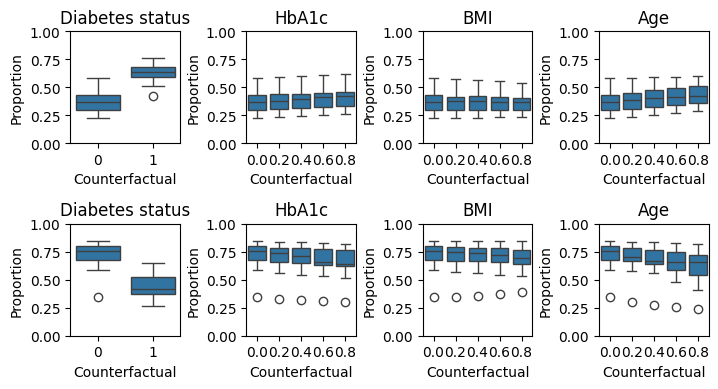

In [48]:
fig, axes = plt.subplots(2, 4, figsize=(1.8*4, 2*2))
sns.boxplot(y = 'Proportion', x = 'Counterfactual', data = ND_diabetes_cf, ax=axes[0,0])
axes[0,0].set_ylim(0,1.0)
axes[0,0].set_title("Diabetes status")
sns.boxplot(y = 'Proportion', x = 'Counterfactual', data = ND_HbA1c_cf, ax=axes[0,1])
axes[0,1].set_ylim(0,1.0)
axes[0,1].set_title("HbA1c")
sns.boxplot(y = 'Proportion', x = 'Counterfactual', data = ND_BMI_cf, ax=axes[0,2])
axes[0,2].set_ylim(0,1.0)
axes[0,2].set_title("BMI")
sns.boxplot(y = 'Proportion', x = 'Counterfactual', data = ND_Age_cf, ax=axes[0,3])
axes[0,3].set_ylim(0,1.0)
axes[0,3].set_title("Age")

sns.boxplot(y = 'Proportion', x = 'Counterfactual', data = T2D_diabetes_cf, ax=axes[1,0])
axes[1,0].set_ylim(0,1.0)
axes[1,0].set_title("Diabetes status")
sns.boxplot(y = 'Proportion', x = 'Counterfactual', data = T2D_HbA1c_cf, ax=axes[1,1])
axes[1,1].set_ylim(0,1.0)
axes[1,1].set_title("HbA1c")
sns.boxplot(y = 'Proportion', x = 'Counterfactual', data = T2D_BMI_cf, ax=axes[1,2])
axes[1,2].set_ylim(0,1.0)
axes[1,2].set_title("BMI")
sns.boxplot(y = 'Proportion', x = 'Counterfactual', data = T2D_Age_cf, ax=axes[1,3])
axes[1,3].set_ylim(0,1.0)
axes[1,3].set_title("Age")
plt.tight_layout()
plt.savefig('../figures/F2C.pdf')

### Running ChromVAR

In [49]:
recon_original = sc.read_h5ad("../data/Pancreas/recon_original.h5ad")
recon_cf = sc.read_h5ad("../data/Pancreas/recon_cf.h5ad")

In [50]:
dev_original = sc.read_h5ad("../data/Pancreas/dev_original.h5ad")
dev_cf = sc.read_h5ad("../data/Pancreas/dev_cf.h5ad")

In [51]:
motifs_cf = permutation_test(dev_cf, groupby = "Disease", group1 = "T2D", group2="ND")

In [52]:
dev_original.obs['predicted_subtype'] = dev_original.obs['predicted_subtype'].replace({0: 'beta1', 1: 'beta2'})

In [53]:
motifs_subtypes = permutation_test(dev_original, groupby = "predicted_subtype", group1 = "beta1", group2="beta2")

In [54]:
rejected, pvals_corrected, _, _ = multipletests(np.array(motifs_subtypes['pval']), alpha=0.05, method='fdr_bh')
motifs_subtypes['FDR'] = pvals_corrected
rejected, pvals_corrected, _, _ = multipletests(np.array(motifs_cf['pval']), alpha=0.05, method='fdr_bh')
motifs_cf['FDR'] = pvals_corrected


### Correlation to GSIS

In [55]:
# Process RNA-seq and GSIS
RNA = pd.read_csv("../../Reproducibility/data/Pancreas/proc_rnaseq.csv", index_col=0)
donor = pd.read_csv("../../Reproducibility/data/Pancreas/donor.csv")
isolation = pd.read_csv("../../Reproducibility/data/Pancreas/isolation.csv")
GSIS = pd.read_csv("../../Reproducibility/data/Pancreas/gsis.csv")

GSIS = GSIS[GSIS['gluc_conc_group'] == "1_16.7"]
GSIS_mean = GSIS.groupby("record_id").mean()
GSIS_mean.index.name = None
RNA = RNA.T
gene_names = RNA.columns.tolist()
RNA = pd.merge(RNA, GSIS_mean[['stim_index','culturetime2']], left_index=True, right_index=True)
RNA = pd.merge(RNA, donor[['record_id', 'donorage','donorsex']], left_index=True, right_on='record_id')
RNA = pd.merge(RNA, isolation[['record_id', 'coldischemiatime','puritypercentage','trappedpercentage','digesttime']], left_on='record_id', right_on='record_id')

# Scaling
RNA["donorsex"] = RNA["donorsex"].map({"Male": 0, "Female": 1})
RNA['donorage'] = (RNA['donorage'] - RNA['donorage'].mean()) / RNA['donorage'].std()
RNA['coldischemiatime'] = (RNA['coldischemiatime'] - RNA['coldischemiatime'].mean()) / RNA['coldischemiatime'].std()
RNA['puritypercentage'] = (RNA['puritypercentage'] - RNA['puritypercentage'].mean()) / RNA['puritypercentage'].std()
RNA['trappedpercentage'] = (RNA['trappedpercentage'] - RNA['trappedpercentage'].mean()) / RNA['trappedpercentage'].std()
RNA['digesttime'] = (RNA['digesttime'] - RNA['digesttime'].mean()) / RNA['digesttime'].std()

In [56]:
# Loop
counter = 0
for gene in gene_names:
    ds = RNA[[gene, 'culturetime2', 'donorage','donorsex', 'coldischemiatime','puritypercentage','trappedpercentage','digesttime','stim_index']].copy()
    ds = ds.dropna()
    ds[gene] = (ds[gene] - ds[gene].mean()) / ds[gene].std()
    x = ds[[gene, 'culturetime2', 'donorage','donorsex', 'coldischemiatime','puritypercentage','trappedpercentage','digesttime','stim_index']]
    x = add_constant(x)
    ols_model = OLS(ds['stim_index'].values, x)
    fit = ols_model.fit()
    coef = fit.params[gene]
    pval = fit.pvalues[gene]

    res_tmp = pd.DataFrame({
        'Entrez': gene,
        'Pearson': coef,
        'Pvalue': pval
    }, index = [counter])
    if counter == 0:
        targets = res_tmp
    else:
        targets = pd.concat((targets,res_tmp))
    counter += 1
    

In [57]:
# Initialize mygene
mg = mygene.MyGeneInfo()

# Query Entrez spearmanro get gene symbols
results = mg.querymany(targets['Entrez'].tolist(), scopes='entrezgene', fields='symbol', species='human')

# Convert to DataFrame for filtering
results_df = pd.DataFrame(results)

# Filter: keep only entries that are NOT ambiguous (i.e., not duplicated or missing)
filtered = results_df[
    (results_df['notfound'] != True) &   # Remove entries not found
    (~results_df.duplicated('query', keep=False))  # Remove duplicated queries (ambiguous)
]
filtered['Entrez'] = filtered['query'].astype(int)

# Merge back with original df on Entrez ID
targets_clean = targets.merge(filtered[['Entrez', 'symbol']], left_on='Entrez', right_on='Entrez', how='inner')

2025-10-14 13:18:10 WARNING  Input sequence provided is already in string format. No operation performed
2025-10-14 13:18:10 WARNING  Input sequence provided is already in string format. No operation performed
2025-10-14 13:18:10 INFO     querying 1-1000 ...
2025-10-14 13:18:12 INFO     HTTP Request: POST https://mygene.info/v3/query/ "HTTP/1.1 200 OK"
2025-10-14 13:18:13 INFO     querying 1001-2000 ...
2025-10-14 13:18:14 INFO     HTTP Request: POST https://mygene.info/v3/query/ "HTTP/1.1 200 OK"
2025-10-14 13:18:15 INFO     querying 2001-3000 ...
2025-10-14 13:18:16 INFO     HTTP Request: POST https://mygene.info/v3/query/ "HTTP/1.1 200 OK"
2025-10-14 13:18:17 INFO     querying 3001-4000 ...
2025-10-14 13:18:18 INFO     HTTP Request: POST https://mygene.info/v3/query/ "HTTP/1.1 200 OK"
2025-10-14 13:18:19 INFO     querying 4001-5000 ...
2025-10-14 13:18:20 INFO     HTTP Request: POST https://mygene.info/v3/query/ "HTTP/1.1 200 OK"
2025-10-14 13:18:21 INFO     querying 5001-6000 ...
2

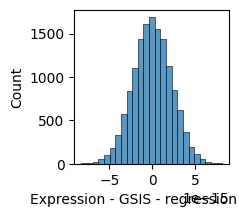

In [58]:
fig, ax = plt.subplots(1, 1, figsize=(2,2))

sns.histplot(targets_clean.Pearson, bins = 25) 
plt.xlabel('Expression - GSIS - regression beta')
plt.ylabel('Count')
plt.savefig('../figuresS5F.pdf')

In [59]:
motif_metadata = pd.read_csv("../data/Pancreas/metadata.tsv", sep="\t")

In [60]:
targets_motifs = targets_clean[targets_clean['symbol'].isin(motif_metadata['tf_name'])]

In [61]:
rejected, pvals_corrected, _, _ = multipletests(np.array(targets_motifs['Pvalue']), alpha=0.05, method='fdr_bh')
targets_motiftargets_motifs = targets_clean[targets_clean['symbol'].isin(motif_metadata['tf_name'])]
targets_motifs['FDR'] = pvals_corrected
targets_motifs.to_csv("../results/Pancreas/GSIS_motifs_processed.csv")

In [62]:
adata_rna = sc.read_h5ad("../../Reproducibility/data/Pancreas/multiome_RNA_raw.h5ad")
annot = pd.read_csv("../data/Pancreas/GSE200044_multiome_beta_annotation.csv", index_col=1)
annot.index.name = None
adata_rna = adata_rna[adata_rna.obs.index.isin(annot.index),:].copy()
freq = np.array((adata_rna.X > 0).sum(axis = 0)) / adata_rna.shape[0]
sc.pp.normalize_total(adata_rna)
sc.pp.log1p(adata_rna)
avg = np.array(adata_rna.X.mean(axis = 0))
expression = pd.DataFrame({
    'Gene': adata_rna.var.index.tolist(),
    'Frequency': freq.ravel(),
    'Average': avg.ravel()
})

In [63]:
dev_original_df = dev_original.to_df()
dev_original_df['subtype'] = dev_original.obs.subtype
chromvar_deviations = dev_original_df.groupby('subtype').mean().T

dev_cf_df = dev_cf.to_df()
dev_cf_df['batch'] = dev_cf.obs.batch
chromvar_deviations['counterfactual_raw'] = dev_cf_df.groupby('batch').mean().loc['0']
chromvar_deviations['counterfactual_ND'] = dev_cf_df.groupby('batch').mean().loc['1']


In [64]:
# Set threshold
threshold = 0.0
frequency_threshold = 0.01
differential_threshold = 1

# Define up and downregulated motifs
downregulated = motifs_subtypes[(motifs_subtypes['FDR'] <= 0.01) & (motifs_subtypes['stat'] > differential_threshold)]
upregulated = motifs_subtypes[(motifs_subtypes['FDR'] <= 0.01) & (motifs_subtypes['stat'] < -differential_threshold)]

# Get ones with support
motifs_cf_up = motifs_cf.loc[upregulated.index,:]
upregulated_any_support = motifs_cf_up[ (motifs_cf_up['stat'] > -threshold)]
motifs_cf_down = motifs_cf.loc[downregulated.index,:]
downregulated_any_support = motifs_cf_down[ (motifs_cf_down['stat'] < threshold)]

# Define unsupported and different support levels
motifs = {}
motifs['upregulated_None'] = upregulated[~upregulated.index.isin(upregulated_any_support.index)]
motifs['downregulated_None'] = downregulated[~downregulated.index.isin(downregulated_any_support.index)]
motifs['upregulated_Support'] = upregulated_any_support
motifs['downregulated_Support'] = downregulated_any_support

In [65]:
chromvar_deviations['subtypes_FDR'] = motifs_subtypes['FDR'] 
chromvar_deviations['cf_FDR'] = motifs_cf['FDR'] 

In [66]:
chromvar_deviations['delta_b2-b1'] = chromvar_deviations['beta_2'] - chromvar_deviations['beta_1']
chromvar_deviations['delta_raw-cf'] = chromvar_deviations['counterfactual_ND'] - chromvar_deviations['counterfactual_raw']

In [67]:
chromvar_deviations['group'] = 'Unaffected'

In [68]:
chromvar_deviations.loc[motifs['upregulated_None'].index, 'group'] = 'upregulated_None'
chromvar_deviations.loc[motifs['downregulated_None'].index, 'group'] = 'downregulated_None'
chromvar_deviations.loc[motifs['upregulated_Support'].index, 'group'] = 'upregulated_Support'
chromvar_deviations.loc[motifs['downregulated_Support'].index, 'group'] = 'downregulated_Support'


In [69]:
chromvar_deviations['regulation'] = 'Unregulated'
chromvar_deviations.loc[motifs['upregulated_None'].index, 'regulation'] = 'Upregulated'
chromvar_deviations.loc[motifs['downregulated_None'].index, 'regulation'] = 'Downregulated'
chromvar_deviations.loc[motifs['upregulated_Support'].index, 'regulation'] = 'Upregulated'
chromvar_deviations.loc[motifs['downregulated_Support'].index, 'regulation'] = 'Downregulated'

chromvar_deviations['Support'] = 'Nan'
chromvar_deviations.loc[motifs['upregulated_None'].index, 'Support'] = 'Unsupported'
chromvar_deviations.loc[motifs['downregulated_None'].index, 'Support'] = 'Unsupported'
chromvar_deviations.loc[motifs['upregulated_Support'].index, 'Support'] = 'Supported'
chromvar_deviations.loc[motifs['downregulated_Support'].index, 'Support'] = 'Supported'

In [70]:
chromvar_deviations.to_csv('../results/Pancreas/cf_support.tsv',
          sep=";",         
          decimal=",",      
          float_format="%.10g")

In [71]:
palette = {'Unaffected': 'lightgray', 'upregulated_None': 'darksalmon', 'upregulated_Support': 'firebrick', 'downregulated_None':'cornflowerblue', 'downregulated_Support': 'royalblue'}

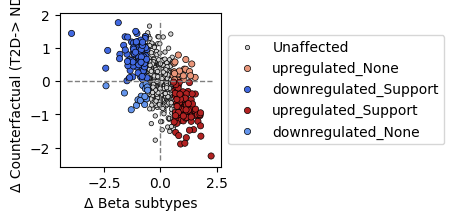

In [72]:
fig, ax = plt.subplots(1, 1, figsize=(2.6,2))
plt.hlines(0, xmin = chromvar_deviations['delta_b2-b1'].min()*1.05, xmax = chromvar_deviations['delta_b2-b1'].max()*1.05,linestyles = '--', color = 'grey', linewidth = 1 )
plt.vlines(0, ymin = chromvar_deviations['delta_raw-cf'].min()*1.05, ymax = chromvar_deviations['delta_raw-cf'].max()*1.05,linestyles = '--', color = 'grey', linewidth = 1 )

sns.scatterplot(chromvar_deviations[chromvar_deviations.group == 'Unaffected'], x = 'delta_b2-b1', y = 'delta_raw-cf', hue = 'group', palette = palette, edgecolor = 'k', linewidth = 0.5, s = 10)
sns.scatterplot(chromvar_deviations[chromvar_deviations.group != 'Unaffected'], x = 'delta_b2-b1', y = 'delta_raw-cf', hue = 'group', palette = palette, edgecolor = 'k', linewidth = 0.5, s = 20)

box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
lim = max(chromvar_deviations['delta_b2-b1'].abs().max(), chromvar_deviations['delta_raw-cf'].abs().max())
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel(u'Δ Beta subtypes')
plt.ylabel(u'Δ Counterfactual (T2D-> ND)')
plt.savefig('../figures/F2D.pdf')

2025-10-14 13:18:46 INFO     Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-10-14 13:18:46 INFO     Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


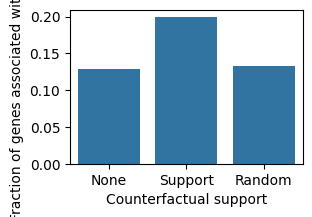

In [73]:
# Set threshold
threshold = 0.0
frequency_threshold = 0.01
differential_threshold = 1

# Define up and downregulated motifs
downregulated = motifs_subtypes[(motifs_subtypes['FDR'] <= 0.01) & (motifs_subtypes['stat'] > differential_threshold)]
upregulated = motifs_subtypes[(motifs_subtypes['FDR'] <= 0.01) & (motifs_subtypes['stat'] < -differential_threshold)]

# Get ones with support
motifs_cf_up = motifs_cf.loc[upregulated.index,:]
upregulated_any_support = motifs_cf_up[ (motifs_cf_up['stat'] > -threshold)]
motifs_cf_down = motifs_cf.loc[downregulated.index,:]
downregulated_any_support = motifs_cf_down[ (motifs_cf_down['stat'] < threshold)]

# Define unsupported and different support levels
motifs = {}
motifs['upregulated_None'] = upregulated[~upregulated.index.isin(upregulated_any_support.index)]
motifs['downregulated_None'] = downregulated[~downregulated.index.isin(downregulated_any_support.index)]
motifs['upregulated_Support'] = upregulated_any_support
motifs['downregulated_Support'] = downregulated_any_support

# Get motif cluter ID
for key in motifs.keys():
    motifs[key] = [s.split(":")[0] for s in motifs[key].index]
    
# Get list of TFs as a dictionary
tfs = {}
for key in motifs.keys():
    tfs[key] = list(motif_metadata[motif_metadata['cluster'].isin(motifs[key])]['tf_name'].unique())

# Combine
for key in tfs.keys():
    df_tmp = pd.DataFrame({
        'TF': tfs[key],
        'Support': key.split("_")[1],
        'Direction': key.split("_")[0]
    })
    
    if key == list(tfs.keys())[0]:
        combined = df_tmp
    else:
        combined = pd.concat((combined, df_tmp))
        
# Keep only unique TFs 
priority_order = {"Support": 0, "None": 1}
combined["Priority"] = combined["Support"].map(priority_order)
combined = combined.sort_values("Priority")
combined = combined.drop_duplicates(subset="TF", keep="first")
combined = combined.drop(columns="Priority")
combined = pd.merge(combined, targets_motifs[['Pearson','Pvalue','symbol','FDR']], left_on='TF', right_on='symbol')
combined = pd.merge(combined, expression, left_on='TF', right_on='Gene')

# Calculate random sets
all_tfs = pd.DataFrame({'TF': motif_metadata[motif_metadata['cluster'].isin([s.split(":")[0] for s in motifs_subtypes.index] )]['tf_name'].unique()})
all_tfs = all_tfs[all_tfs['TF'].isin(targets_motifs['symbol'])]
all_tfs = all_tfs[all_tfs['TF'].isin(expression['Gene'])]
random_size = []
for i in range(1000):
    sampled_tfs = all_tfs.sample(n=100)
    sampled_tfs = sampled_tfs[sampled_tfs['TF'].isin(targets_motifs[targets_motifs['FDR'] <= 0.01]['symbol'])]
    sampled_tfs = sampled_tfs[sampled_tfs['TF'].isin(expression[ expression['Frequency'] >= frequency_threshold]['Gene'])]
    random_size.append(len(sampled_tfs) / 100)
random_size = np.array(random_size).mean()

# Get fractions
overlap = len(combined[ (combined['Support'] == "Support") & (combined['Frequency'] >= frequency_threshold) & (combined['FDR'] <= 0.05)])
size = len(combined[ (combined['Support'] == "Support")])
support = overlap / size

overlap = len(combined[ (combined['Support'] == "None") & (combined['Frequency'] >= frequency_threshold) & (combined['FDR'] <= 0.05)])
size = len(combined[ (combined['Support'] == "None")])
no_support = overlap / size

fig, ax = plt.subplots(1, 1, figsize=(3, 2))
sns.barplot([no_support, support, random_size])
plt.xticks(ticks = [0,1,2], labels=['None','Support','Random'])
plt.xlabel("Counterfactual support")
plt.ylabel("Fraction of genes associated with GSIS")
plt.savefig('../figures/F2F.pdf')

2025-10-14 13:18:48 INFO     Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-10-14 13:18:48 INFO     Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


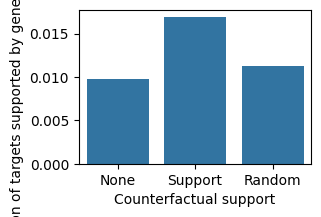

In [74]:
# Import coloc data from redRibbon paper
coloc = pd.read_csv("../data/Pancreas/results.tsv", sep="\t")

# Combine
for key in tfs.keys():
    df_tmp = pd.DataFrame({
        'TF': tfs[key],
        'Support': key.split("_")[1],
        'Direction': key.split("_")[0]
    })
    
    if key == list(tfs.keys())[0]:
        combined = df_tmp
    else:
        combined = pd.concat((combined, df_tmp))
        
# Keep only unique TFs 
priority_order = {"Support": 0, "None": 1}
combined["Priority"] = combined["Support"].map(priority_order)
combined = combined.sort_values("Priority")
combined = combined.drop_duplicates(subset="TF", keep="first")
combined = combined.drop(columns="Priority")
combined = pd.merge(combined, expression, left_on='TF', right_on='Gene')
combined['hit'] = combined['TF'].isin(coloc['shortid']).astype(int)

# Calculate random sets
all_tfs = pd.DataFrame({'TF': motif_metadata[motif_metadata['cluster'].isin([s.split(":")[0] for s in motifs_subtypes.index] )]['tf_name'].unique()})
all_tfs = all_tfs[all_tfs['TF'].isin(expression['Gene'])]

random_size = []
for i in range(1000):
    sampled_tfs = all_tfs.sample(n=50)
    sampled_tfs = sampled_tfs[sampled_tfs['TF'].isin(coloc['shortid'])]
    sampled_tfs = sampled_tfs[sampled_tfs['TF'].isin(expression[ expression['Frequency'] >= frequency_threshold]['Gene'])]
    random_size.append(len(sampled_tfs) / 50)
    
random_size = np.array(random_size).mean()

# Get fractions
overlap = len(combined[ (combined['Support'] == "Support") & (combined['Frequency'] >= frequency_threshold) & (combined['hit'] == 1)])
size = len(combined[ (combined['Support'] == "Support")])
support = overlap / size

overlap = len(combined[ (combined['Support'] == "None") & (combined['Frequency'] >= frequency_threshold) & (combined['hit'] == 1)])
size = len(combined[ (combined['Support'] == "None")])
no_support = overlap / size

fig, ax = plt.subplots(1, 1, figsize=(3, 2))

sns.barplot([no_support, support,random_size])
plt.xticks(ticks = [0,1,2], labels=['None','Support','Random'])
plt.xlabel("Counterfactual support")
plt.ylabel("Fraction of targets supported by genetic evidence")
plt.savefig('../figures/F2E.pdf')